# Contextual Bandits: Policy Learning Demo

This notebook demonstrates contextual bandit optimization using policy gradient methods. We compare learned policies against random assignment and visualize treatment surfaces and regret.

In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *
from demo.contextual_bandit_dgp import Complex, IHDP, Simple
from demo.reinforcement_learning.policy_gradient import PolicyGradient

---
## 1. Setting Up the Data Generating Process (DGP)

We provide three DGP options:
- **Simple**: Linear reward surfaces (fast, interpretable)
- **Complex**: Gaussian Process reward surfaces with RBF kernel (nonlinear, smooth)
- **IHDP**: Semi-synthetic DGP based on real Infant Health and Development Program data (25 fixed features)

All implement the same interface, so you can swap them easily.

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configuration
n_arms = 3
n_features = 2  # Initial setting (will be updated by DGP)

# Choose your DGP (uncomment one):

# Option 1: Simple (linear) DGP
dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=0.3)

# Option 2: Complex (GP) DGP
# dgp = Complex(n_arms=n_arms, n_features=n_features, length_scale=1.0, amplitude=1.0)

# Option 3: IHDP (semi-synthetic from real data, 25 features)
# dgp = IHDP(n_arms=n_arms, setting='A')

# Get n_features from DGP (important for IHDP which has fixed features)
n_features = dgp.n_features

print(f"DGP: {type(dgp).__name__}")
print(f"Number of arms: {n_arms}")
print(f"Number of features: {n_features}")

DGP: IHDP
Number of arms: 3
Number of features: 25


---
## 2. Visualizing the Data Structure

Before training, let's understand the structure of the problem by visualizing:
- Expected reward surfaces for each arm
- The true optimal treatment policy
- The optimal reward surface

In [3]:
# Create a grid of points for visualization (first 2 features)
grid_size = 100
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid_2d = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])

# For DGPs with more than 2 features, we need full-dimensional data
# We'll vary the first 2 features on our grid and marginalize over the rest
if n_features > 2:
    # Create base contexts by sampling from the DGP (or using zeros for other features)
    # Using zeros keeps other features fixed at their mean (for standardized data)
    grid_points = dgp.x(len(grid_2d))
    grid_points[:, 0] = grid_2d[:, 0]
    grid_points[:, 1] = grid_2d[:, 1]
else:
    grid_points = grid_2d

# Compute rewards for each arm at each grid point
rewards_by_arm = np.zeros((len(grid_points), n_arms))
for arm in range(n_arms):
    arm_actions = np.full(len(grid_points), arm)
    rewards_by_arm[:, arm] = dgp.r(arm_actions, grid_points)

# Get true optimal arms and rewards
true_optimal_arms = dgp.a_star(grid_points)
optimal_rewards_grid = dgp.r_star(grid_points)

print(f"Grid: {grid_size}x{grid_size} = {len(grid_points)} points")
print(f"Visualizing features 0 and 1 (other {max(0, n_features-2)} while randomizing over others)")

Grid: 100x100 = 10000 points
Visualizing features 0 and 1 (other 23 features held at 0)


### 2.1 Expected Reward Surfaces by Arm

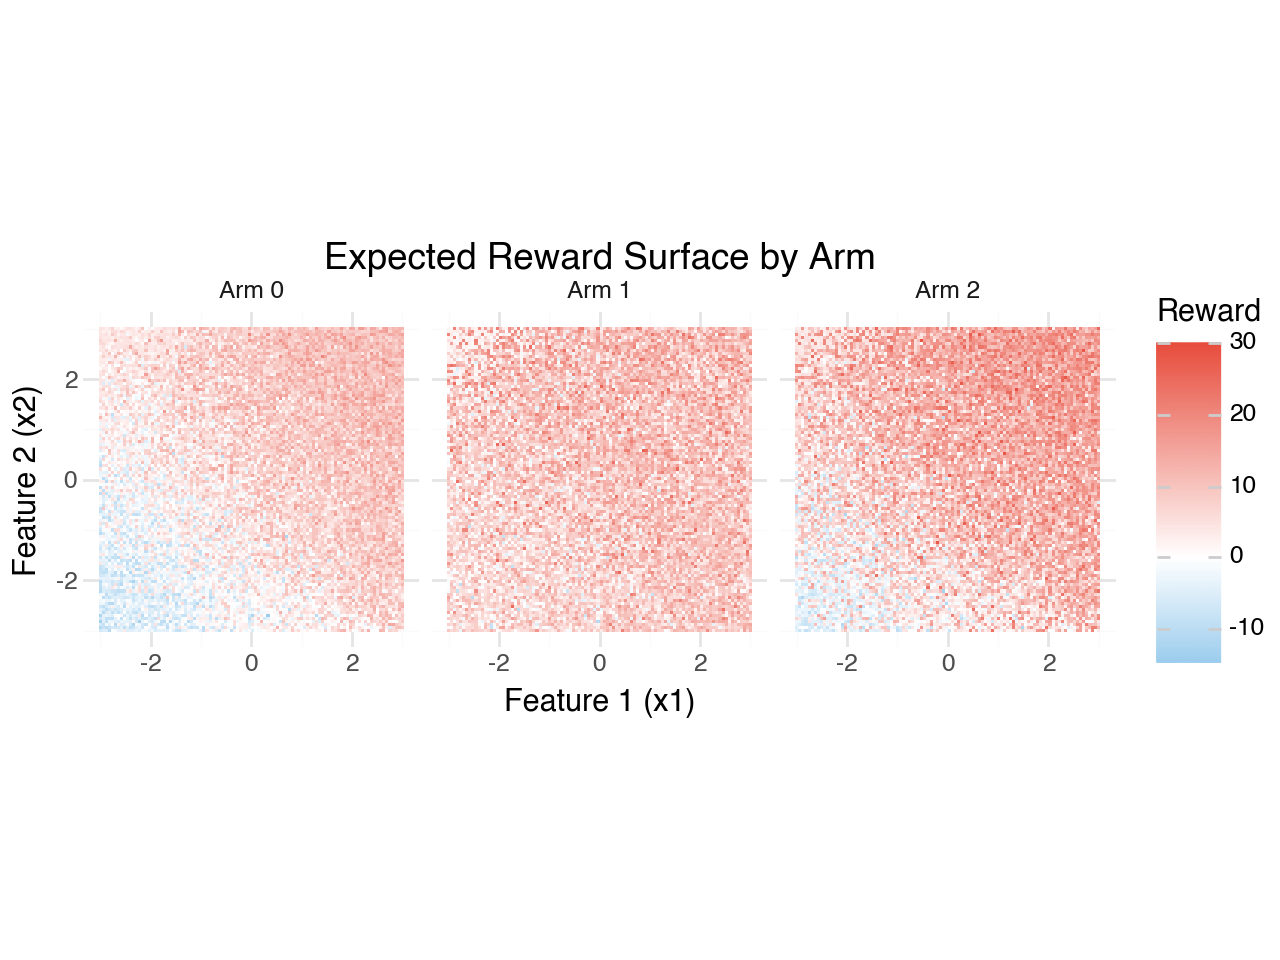

In [4]:
# Create dataframe for reward surfaces
df_rewards_list = []
for arm in range(n_arms):
    df_arm = pd.DataFrame({
        'x1': grid_points[:, 0],
        'x2': grid_points[:, 1],
        'reward': rewards_by_arm[:, arm],
        'arm': f'Arm {arm}'
    })
    df_rewards_list.append(df_arm)

df_rewards = pd.concat(df_rewards_list, ignore_index=True)

p_rewards = (ggplot(df_rewards, aes(x='x1', y='x2', fill='reward')) +
             geom_tile() +
             scale_fill_gradient2(low='#3498db', mid='white', high='#e74c3c', midpoint=0) +
             facet_wrap('~arm', ncol=3) +
             labs(title='Expected Reward Surface by Arm',
                  x='Feature 1 (x1)',
                  y='Feature 2 (x2)',
                  fill='Reward') +
             theme_minimal() +
             coord_fixed())

p_rewards

### 2.2 True Optimal Treatment Policy

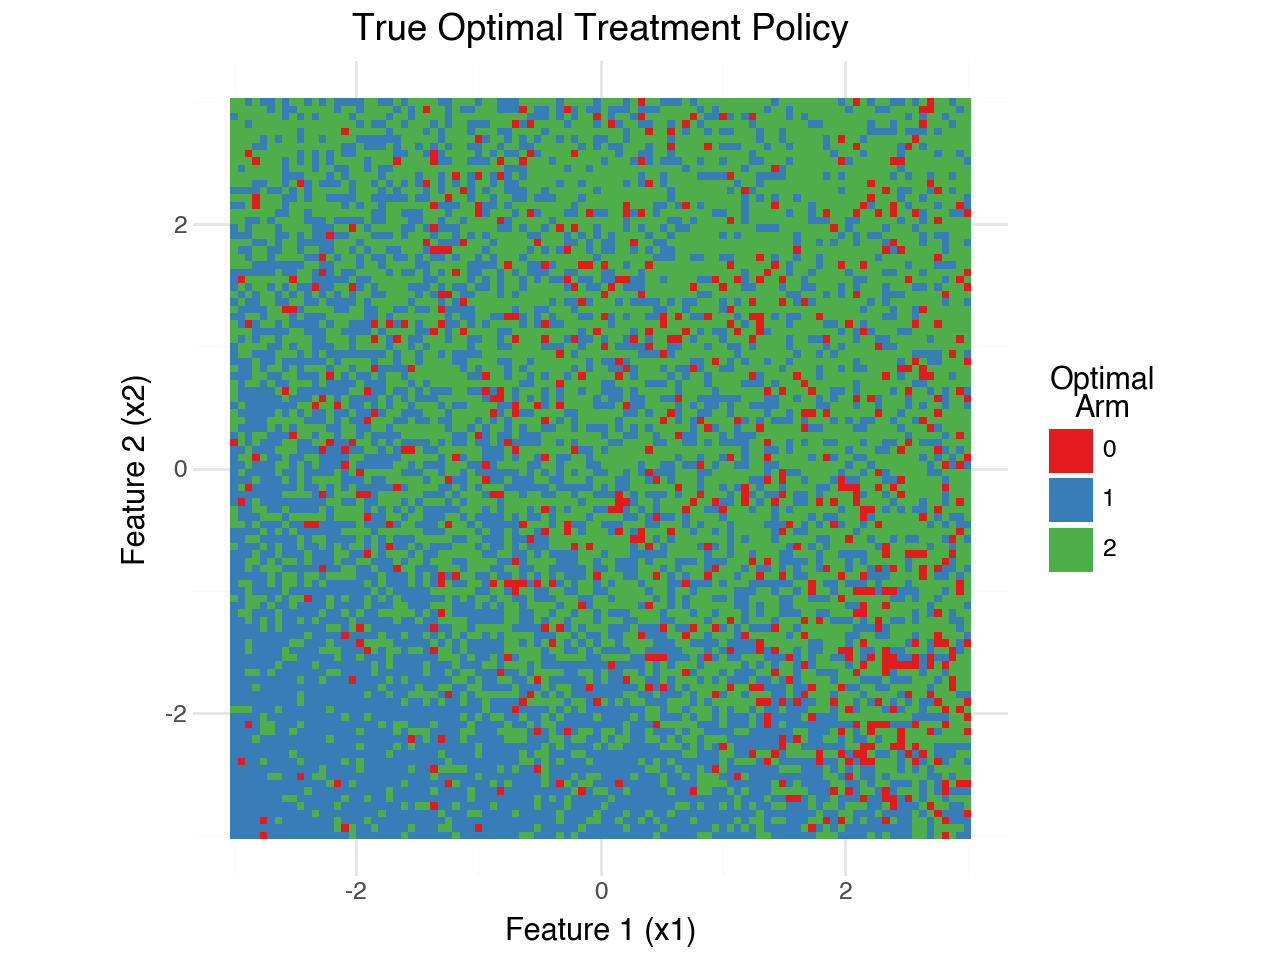

In [5]:
# Create dataframe for true optimal surface
df_true = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'optimal_arm': true_optimal_arms.astype(str)
})

p_true = (ggplot(df_true, aes(x='x1', y='x2', fill='optimal_arm')) +
          geom_tile() +
          scale_fill_brewer(type='qual', palette='Set1') +
          labs(title='True Optimal Treatment Policy',
               x='Feature 1 (x1)',
               y='Feature 2 (x2)',
               fill='Optimal\nArm') +
          theme_minimal() +
          coord_fixed())

p_true

### 2.3 Optimal Reward Surface

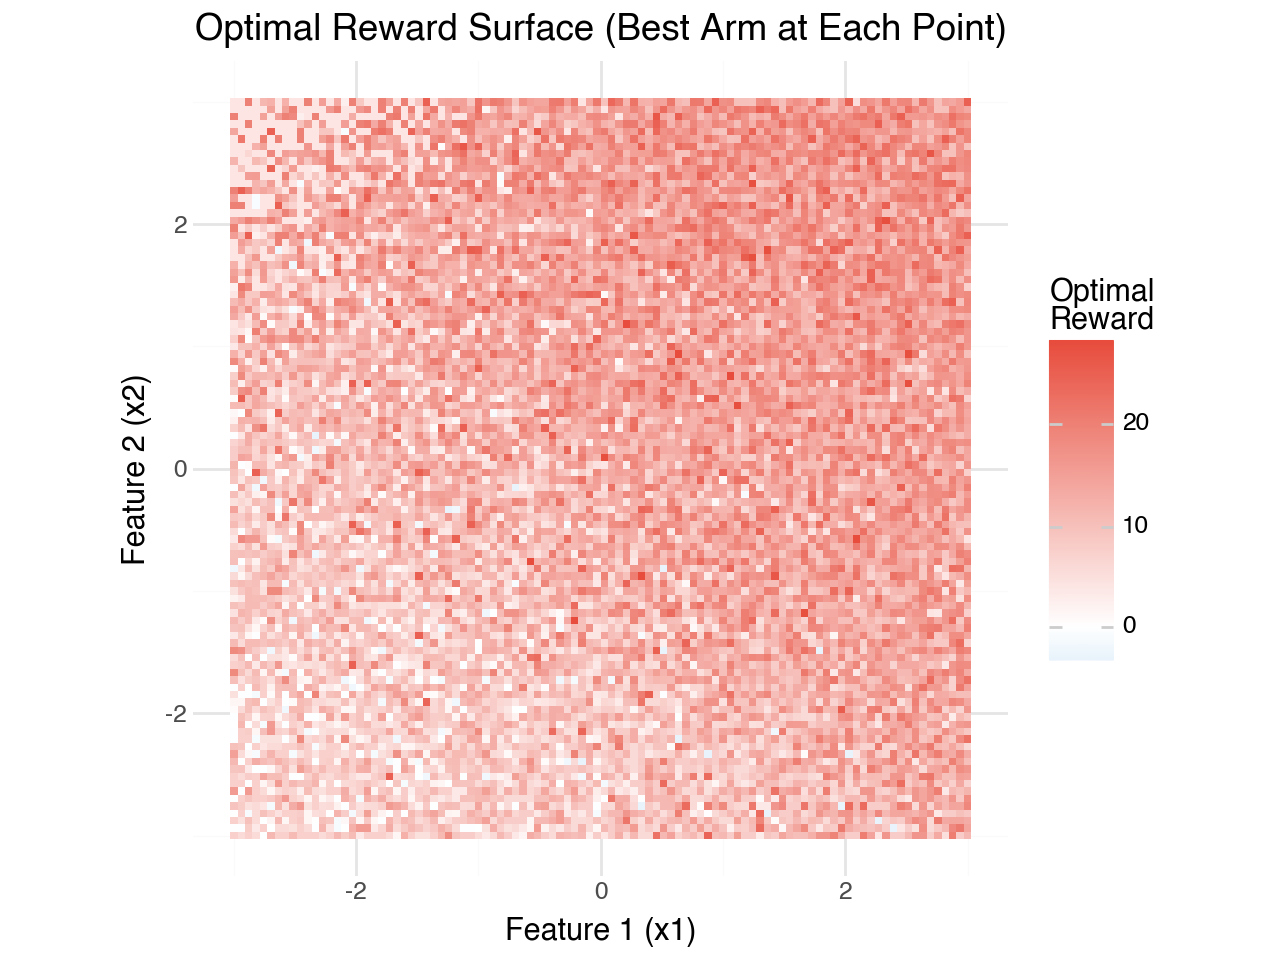

In [6]:
df_optimal_reward = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'optimal_reward': optimal_rewards_grid
})

p_optimal_reward = (ggplot(df_optimal_reward, aes(x='x1', y='x2', fill='optimal_reward')) +
                    geom_tile() +
                    scale_fill_gradient2(low='#3498db', mid='white', high='#e74c3c', midpoint=0) +
                    labs(title='Optimal Reward Surface (Best Arm at Each Point)',
                         x='Feature 1 (x1)',
                         y='Feature 2 (x2)',
                         fill='Optimal\nReward') +
                    theme_minimal() +
                    coord_fixed())

p_optimal_reward

---
## 3. Policy Optimization: Policy Gradient vs Random Assignment

Now we train a policy gradient model online and compare it against pure randomization.

In [7]:
# Initialize the policy gradient model
policy = PolicyGradient(n_features=n_features, n_actions=n_arms, lr=1e-2)

# Training configuration
n_rounds = 200
batch_size = 64

# Storage for results
pg_rewards = []
pg_regrets = []
random_rewards = []
random_regrets = []
pg_optimal_rates = []
random_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = np.random.normal(size=(batch_size, n_features))
    
    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)
    
    # --- Policy Gradient ---
    pg_actions, log_probs = policy.select_actions(contexts)
    pg_observed = dgp.r(pg_actions, contexts)
    policy.finish_batch(pg_observed, pg_actions, log_probs)
    
    pg_rewards.extend(pg_observed)
    pg_regrets.extend(optimal_rewards - pg_observed)
    pg_optimal_rates.append((pg_actions == optimal_arms).mean())
    
    # --- Random Assignment ---
    random_actions = np.random.randint(0, n_arms, size=batch_size)
    random_observed = dgp.r(random_actions, contexts)
    
    random_rewards.extend(random_observed)
    random_regrets.extend(optimal_rewards - random_observed)
    random_optimal_rates.append((random_actions == optimal_arms).mean())

# Convert to arrays
pg_rewards = np.array(pg_rewards)
pg_regrets = np.array(pg_regrets)
random_rewards = np.array(random_rewards)
random_regrets = np.array(random_regrets)
n_samples = len(pg_rewards)

print(f"Training complete: {n_rounds} rounds, {n_samples} total samples")

Training complete: 200 rounds, 12800 total samples


### 3.1 Learned Policy vs True Optimal Policy

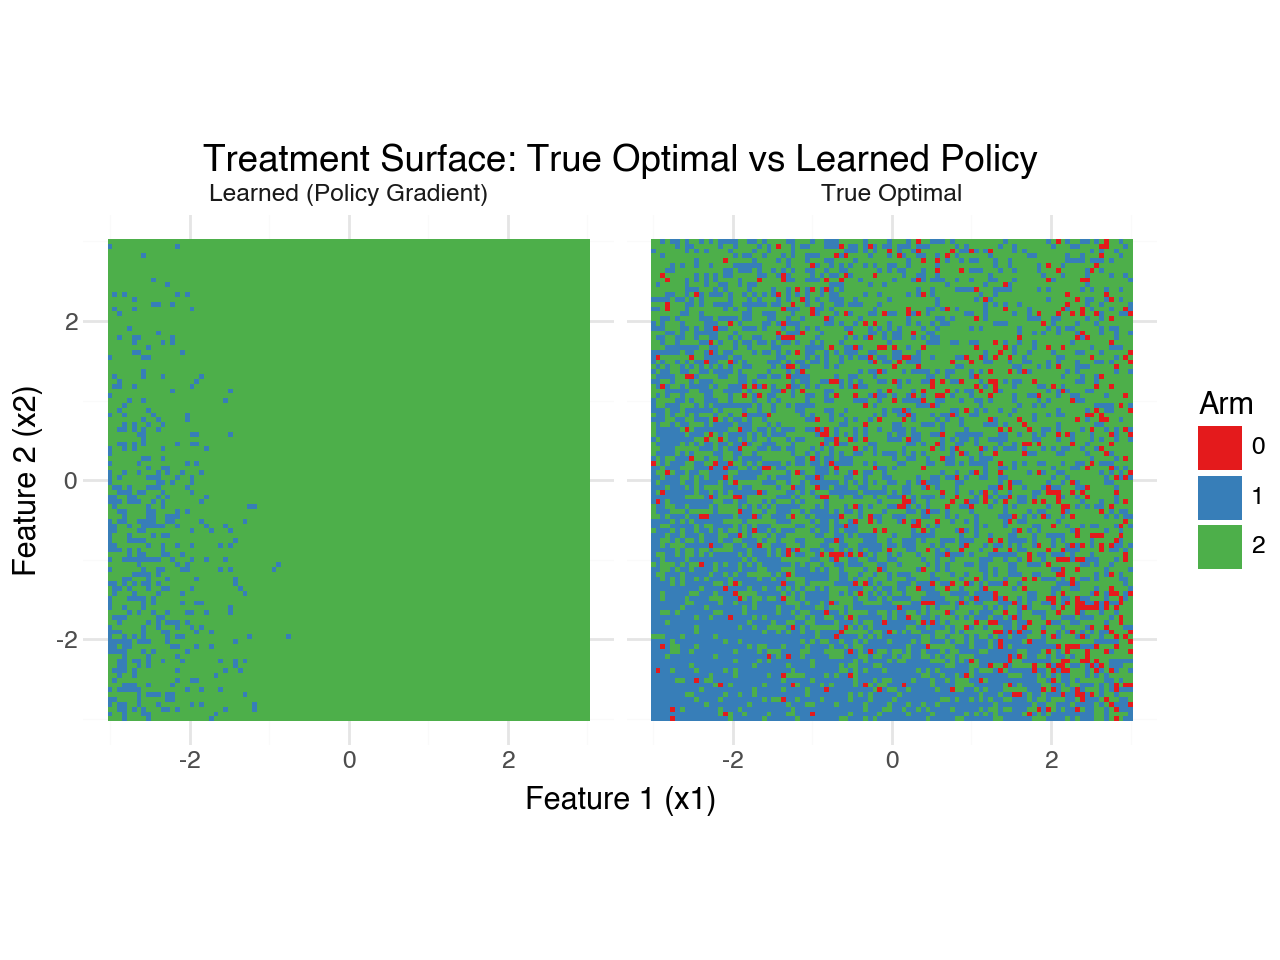

In [8]:
# Get learned policy's predictions on the grid
with torch.no_grad():
    log_probs = policy.forward(torch.from_numpy(grid_points).float())
    learned_arms = torch.argmax(log_probs, dim=1).numpy()

# Create comparison dataframe
df_true_comp = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'arm': true_optimal_arms.astype(str),
    'policy': 'True Optimal'
})

df_learned_comp = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'arm': learned_arms.astype(str),
    'policy': 'Learned (Policy Gradient)'
})

df_comparison = pd.concat([df_true_comp, df_learned_comp], ignore_index=True)

p_comparison = (ggplot(df_comparison, aes(x='x1', y='x2', fill='arm')) +
                geom_tile() +
                scale_fill_brewer(type='qual', palette='Set1') +
                facet_wrap('~policy') +
                labs(title='Treatment Surface: True Optimal vs Learned Policy',
                     x='Feature 1 (x1)',
                     y='Feature 2 (x2)',
                     fill='Arm') +
                theme_minimal() +
                coord_fixed())

p_comparison

### 3.2 Policy Agreement Map

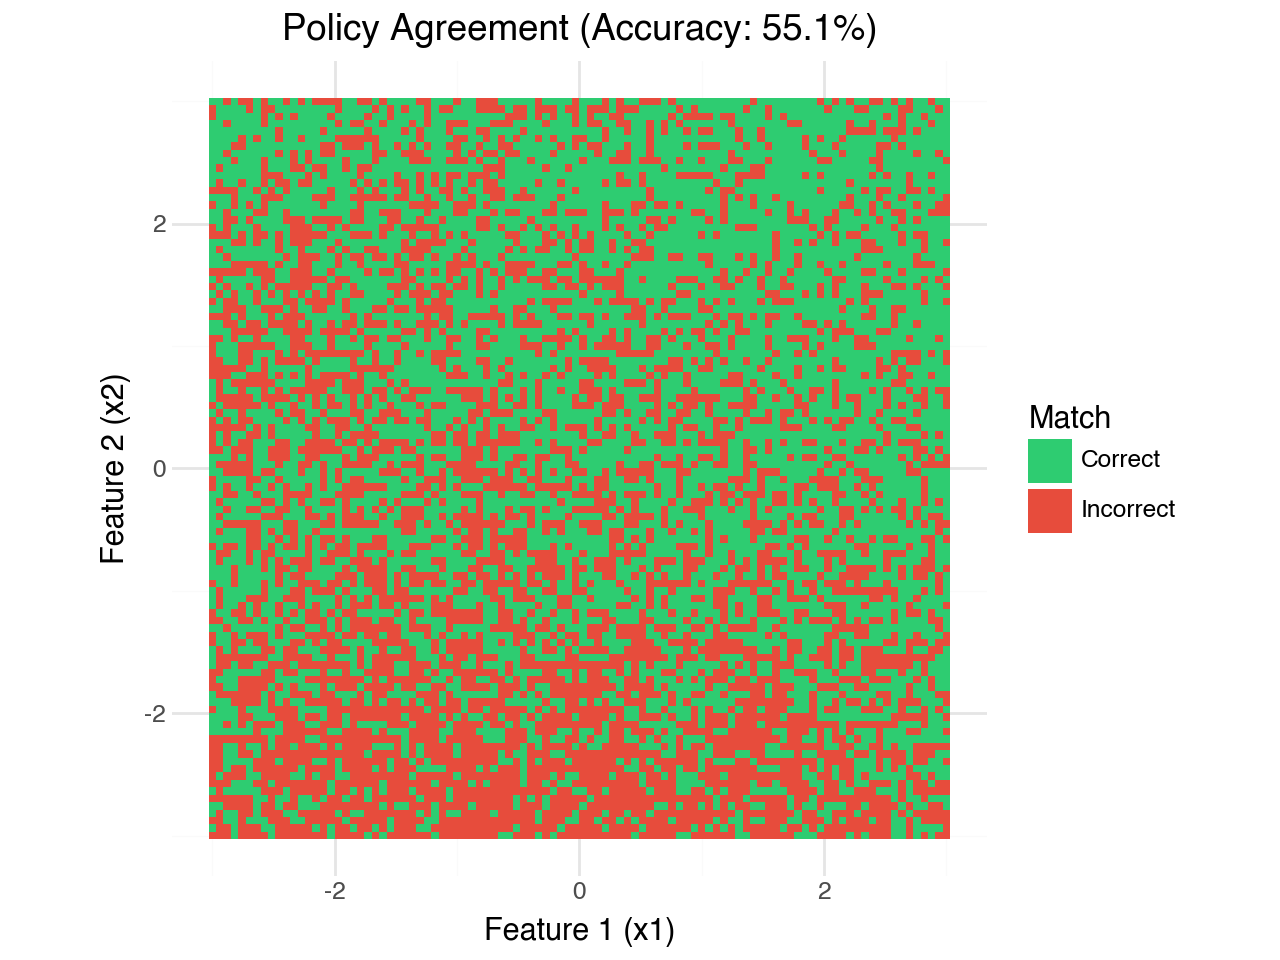

In [9]:
# Where does the learned policy match the true optimal?
agreement = (true_optimal_arms == learned_arms)
accuracy = agreement.mean() * 100

df_agreement = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'matches': np.where(agreement, 'Correct', 'Incorrect')
})

p_agreement = (ggplot(df_agreement, aes(x='x1', y='x2', fill='matches')) +
               geom_tile() +
               scale_fill_manual(values={'Correct': '#2ecc71', 'Incorrect': '#e74c3c'}) +
               labs(title=f'Policy Agreement (Accuracy: {accuracy:.1f}%)',
                    x='Feature 1 (x1)',
                    y='Feature 2 (x2)',
                    fill='Match') +
               theme_minimal() +
               coord_fixed())

p_agreement

### 3.3 Optimal Arm Selection Rate Over Time

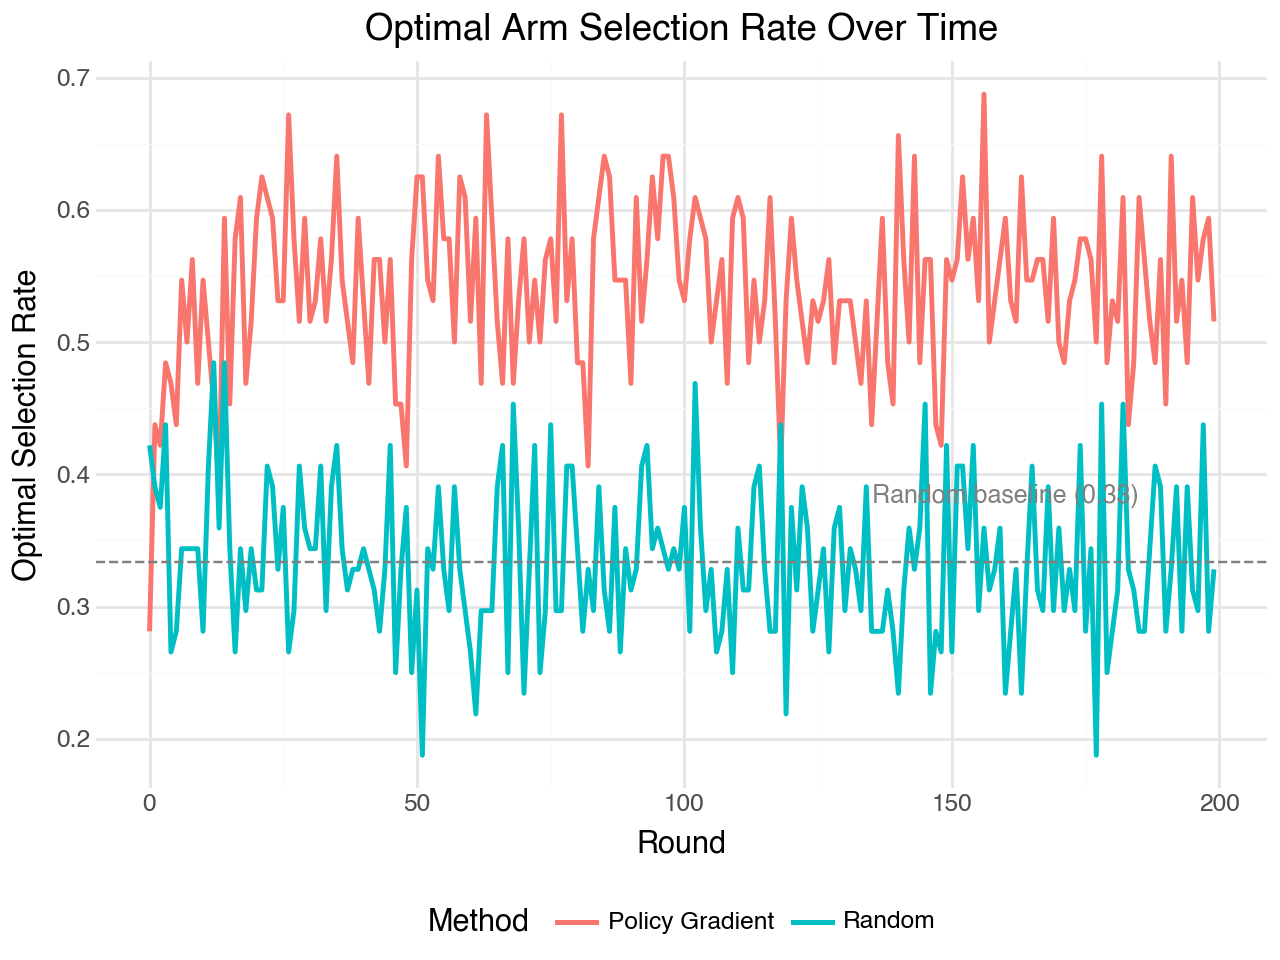

In [10]:
df_optimal_rate = pd.DataFrame({
    'round': list(range(n_rounds)) * 2,
    'optimal_rate': pg_optimal_rates + random_optimal_rates,
    'method': ['Policy Gradient'] * n_rounds + ['Random'] * n_rounds
})

p_optimal_rate = (ggplot(df_optimal_rate, aes(x='round', y='optimal_rate', color='method')) +
                  geom_line(size=1) +
                  geom_hline(yintercept=1/n_arms, linetype='dashed', color='gray') +
                  annotate('text', x=n_rounds*0.8, y=1/n_arms + 0.05, 
                           label=f'Random baseline ({1/n_arms:.2f})', color='gray', size=9) +
                  labs(title='Optimal Arm Selection Rate Over Time',
                       x='Round',
                       y='Optimal Selection Rate',
                       color='Method') +
                  theme_minimal() +
                  theme(legend_position='bottom'))

p_optimal_rate

---
## 4. Regret Analysis

Regret measures the difference between the optimal reward and the observed reward. We analyze both instantaneous and cumulative regret.

In [11]:
# Calculate cumulative regrets
pg_cumulative_regret = np.cumsum(pg_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

print("=" * 60)
print("REGRET SUMMARY")
print("=" * 60)

print(f"\nPolicy Gradient:")
print(f"  Mean instantaneous regret: {pg_regrets.mean():.4f}")
print(f"  Total cumulative regret: {pg_cumulative_regret[-1]:.2f}")

print(f"\nRandom Assignment:")
print(f"  Mean instantaneous regret: {random_regrets.mean():.4f}")
print(f"  Total cumulative regret: {random_cumulative_regret[-1]:.2f}")

print(f"\nImprovement:")
print(f"  Regret reduction: {(1 - pg_cumulative_regret[-1]/random_cumulative_regret[-1])*100:.1f}%")
print("=" * 60)

REGRET SUMMARY

Policy Gradient:
  Mean instantaneous regret: 2.1813
  Total cumulative regret: 27921.24

Random Assignment:
  Mean instantaneous regret: 4.3688
  Total cumulative regret: 55921.21

Improvement:
  Regret reduction: 50.1%


### 4.1 Cumulative Regret Over Time

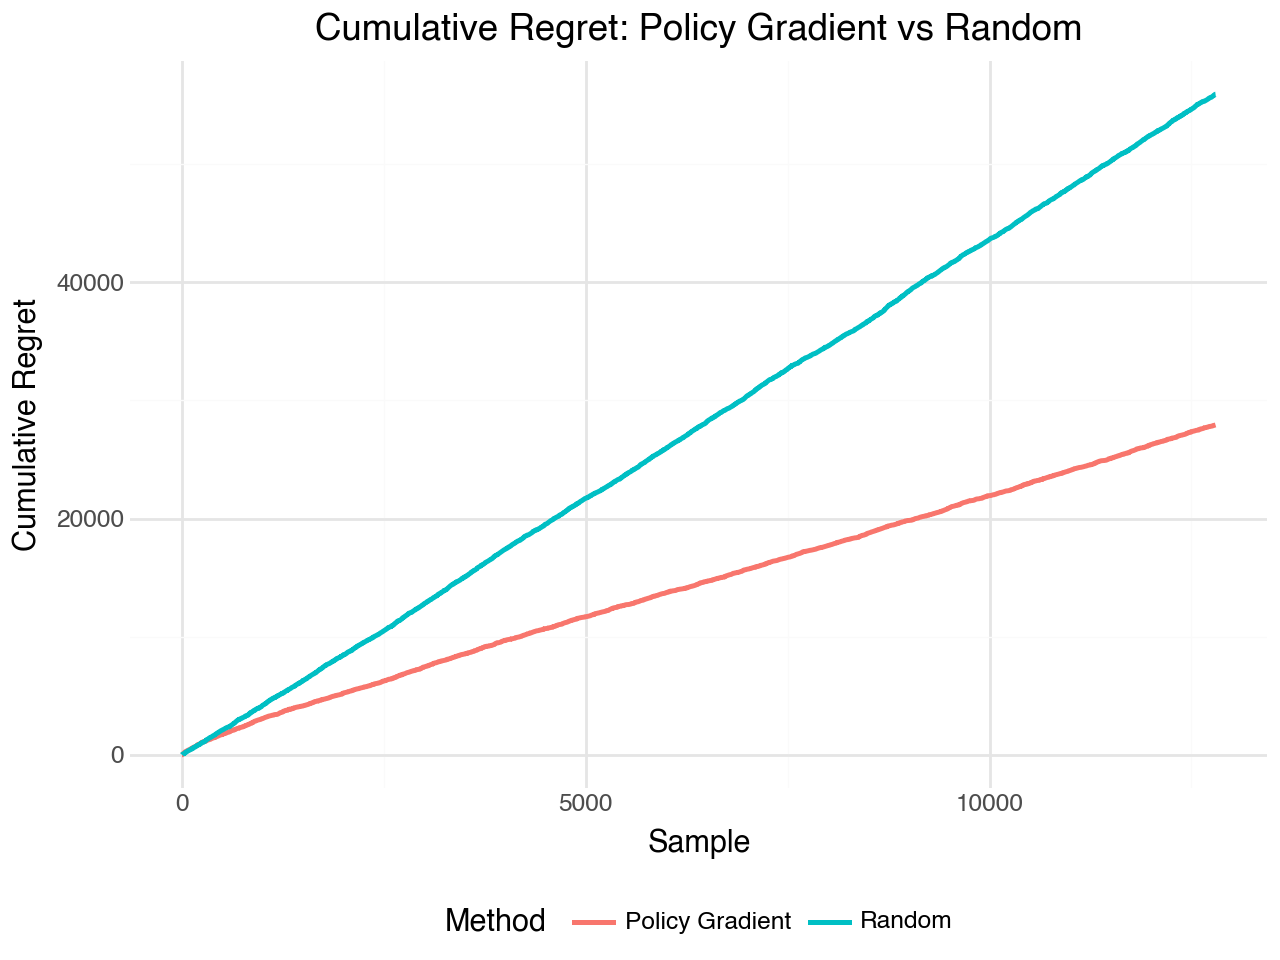

In [12]:
df_cumulative = pd.DataFrame({
    'sample': list(range(n_samples)) * 2,
    'cumulative_regret': np.concatenate([pg_cumulative_regret, random_cumulative_regret]),
    'method': ['Policy Gradient'] * n_samples + ['Random'] * n_samples
})

p_cumulative = (ggplot(df_cumulative, aes(x='sample', y='cumulative_regret', color='method')) +
                geom_line(size=1) +
                labs(title='Cumulative Regret: Policy Gradient vs Random',
                     x='Sample',
                     y='Cumulative Regret',
                     color='Method') +
                theme_minimal() +
                theme(legend_position='bottom'))

p_cumulative

### 4.2 Instantaneous Regret Distribution

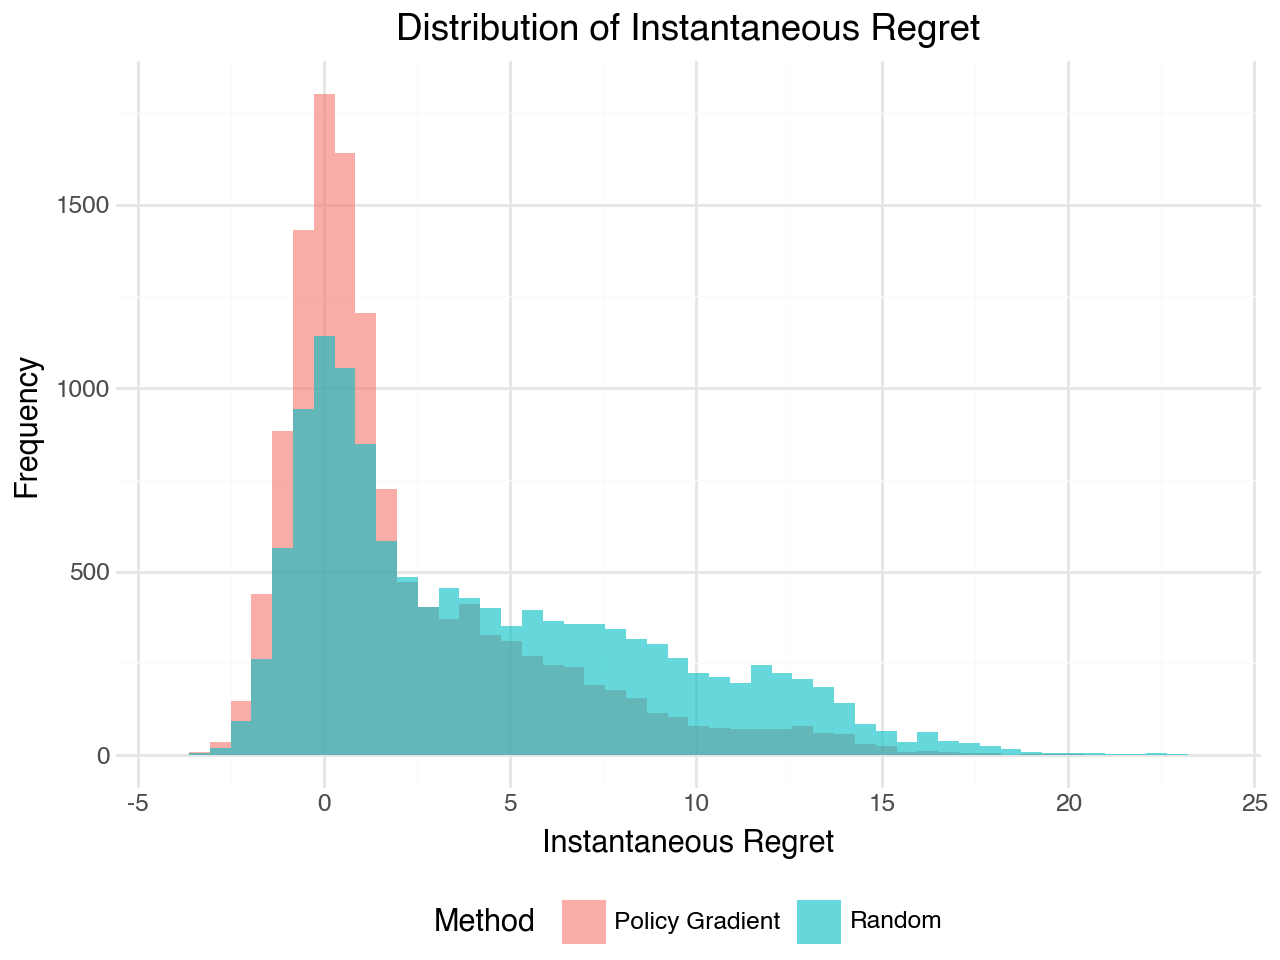

In [13]:
df_inst_regret = pd.DataFrame({
    'regret': np.concatenate([pg_regrets, random_regrets]),
    'method': ['Policy Gradient'] * n_samples + ['Random'] * n_samples
})

p_inst_regret = (ggplot(df_inst_regret, aes(x='regret', fill='method')) +
                 geom_histogram(bins=50, alpha=0.6, position='identity') +
                 labs(title='Distribution of Instantaneous Regret',
                      x='Instantaneous Regret',
                      y='Frequency',
                      fill='Method') +
                 theme_minimal() +
                 theme(legend_position='bottom'))

p_inst_regret

### 4.3 Rolling Average Regret (Learning Curve)

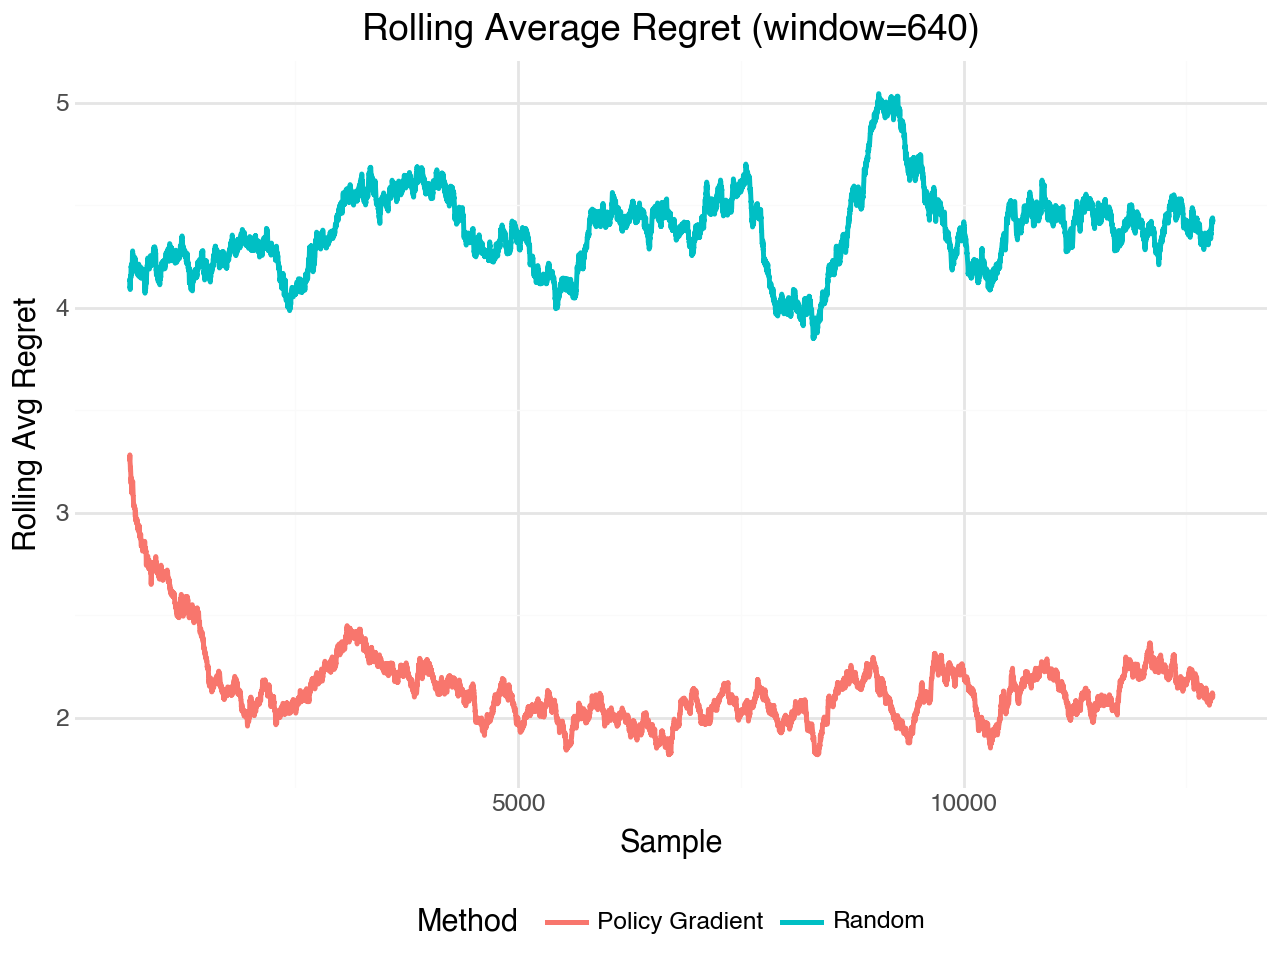

In [14]:
window = 10
rolling_window = batch_size * window
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

df_rolling = pd.DataFrame({
    'sample': list(range(n_samples)) * 2,
    'rolling_regret': np.concatenate([pg_rolling, random_rolling]),
    'method': ['Policy Gradient'] * n_samples + ['Random'] * n_samples
}).dropna()

p_rolling = (ggplot(df_rolling, aes(x='sample', y='rolling_regret', color='method')) +
             geom_line(size=1) +
             labs(title=f'Rolling Average Regret (window={rolling_window})',
                  x='Sample',
                  y='Rolling Avg Regret',
                  color='Method') +
             theme_minimal() +
             theme(legend_position='bottom'))

p_rolling

### 4.4 Summary Statistics

In [15]:
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print(f"\nConfiguration:")
print(f"  DGP: {type(dgp).__name__}")
print(f"  Arms: {n_arms}")
print(f"  Features: {n_features}")
print(f"  Training rounds: {n_rounds}")
print(f"  Batch size: {batch_size}")
print(f"  Total samples: {n_samples}")

print(f"\nPolicy Gradient Performance:")
print(f"  Mean reward: {pg_rewards.mean():.4f}")
print(f"  Mean regret: {pg_regrets.mean():.4f}")
print(f"  Regret std: {pg_regrets.std():.4f}")
print(f"  Final optimal selection rate: {pg_optimal_rates[-1]*100:.1f}%")
print(f"  Policy accuracy on grid: {accuracy:.1f}%")

print(f"\nRandom Assignment Performance:")
print(f"  Mean reward: {random_rewards.mean():.4f}")
print(f"  Mean regret: {random_regrets.mean():.4f}")
print(f"  Regret std: {random_regrets.std():.4f}")
print(f"  Expected optimal selection rate: {1/n_arms*100:.1f}%")

print(f"\nComparison:")
print(f"  Total regret saved: {random_cumulative_regret[-1] - pg_cumulative_regret[-1]:.2f}")
print(f"  Regret reduction: {(1 - pg_cumulative_regret[-1]/random_cumulative_regret[-1])*100:.1f}%")
print("=" * 60)

FINAL SUMMARY

Configuration:
  DGP: IHDP
  Arms: 3
  Features: 25
  Training rounds: 200
  Batch size: 64
  Total samples: 12800

Policy Gradient Performance:
  Mean reward: 9.7970
  Mean regret: 2.1813
  Regret std: 3.6272
  Final optimal selection rate: 51.6%
  Policy accuracy on grid: 55.1%

Random Assignment Performance:
  Mean reward: 7.6095
  Mean regret: 4.3688
  Regret std: 4.8035
  Expected optimal selection rate: 33.3%

Comparison:
  Total regret saved: 27999.98
  Regret reduction: 50.1%
